<a href="https://colab.research.google.com/github/kavmax/computer-vision/blob/master/yolov5-custom-detector/yolov5_train_from_darknet_format.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set BASE_MODEL according to [Pretrained Checkpoints](https://github.com/ultralytics/yolov5/releases)

In [2]:
PROJECT_NAME = "yolov5_train"
BASE_MODEL = "yolov5n6.pt"
TRAIN_BATCH = 32
TRAIN_EPOCHS = 200
VAL_BATCH = 64

# Clone yolov5 repo

In [3]:
! git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12345, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12345 (delta 2), reused 2 (delta 1), pack-reused 12335
Receiving objects: 100% (12345/12345), 12.17 MiB | 30.04 MiB/s, done.
Resolving deltas: 100% (8516/8516), done.


In [4]:
% cd yolov5/
% pip install -qr requirements.txt
% cd ..

/content/yolov5
     |████████████████████████████████| 596 kB 23.4 MB/s 
/content


# Import libraries



In [5]:
import torch
from yolov5 import utils
import torch
from IPython import display
from IPython.display import clear_output
from pathlib import Path
from google.colab import output
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import io
import os
import cv2
import json
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
# display = utils.notebook_init()

# Convert data to yolov5 Pytorch format

Prepare data from Label Studio yolov5 darknet format to pytorch yolov5

In [6]:
# In this step connect to your Google Drive with labeled data with Label Studio

Unzip data

In [7]:
LABELED_DATA_PATH = "/content/drive/MyDrive/yolov5/sky2fly-dandelion/638-labels.zip"

In [8]:
! unzip $LABELED_DATA_PATH
output.clear()

Split data

In [9]:
# Read labels
labels = os.listdir("labels")

# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

train: 542; valid: 76; test: 20


Make dirs for pytorch dataset format

In [10]:
os.makedirs("test/images")
os.makedirs("test/labels")
os.makedirs("train/images")
os.makedirs("train/labels")
os.makedirs("valid/images")
os.makedirs("valid/labels")

In [11]:
def move_files_to_dir(files, dirname):
    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.png"
        shutil.move(f"images/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.move(f"labels/{label_filename}", f"{dirname}/labels/{label_filename}")

# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

% rm -r labels
% rm -r images

Convert yolov5-darknet to yolov5-pytorch description file

In [12]:
descr_darknet = json.load(open("notes.json"))

train_path = "../train/images"
test_path = "../test/images"
valid_path = "../valid/images"

nc = len(descr_darknet["categories"])
names = [category["name"] for category in descr_darknet["categories"]]

print(
    f"train: {train_path}\n"
    f"test: {test_path}\n"
    f"val: {valid_path}\n\n"
    f"nc: {nc}\n"
    f"names: {names}",
)

% rm notes.json
% rm classes.txt

train: ../train/images
test: ../test/images
val: ../valid/images

nc: 5
names: ['coconut', 'dandelion-empty', 'dandelion-full', 'fluff', 'palm']


In [13]:
with open("data.yaml", "w") as file:
    yaml.dump({
        "train": train_path,
        "test": test_path,
        "val": valid_path,
        "nc": nc,
        "names": [f'{name}' for name in names]
    }, stream=file, default_flow_style=None)

In [14]:
print("Now we are ready to train yolov5 model")
! ls 

Now we are ready to train yolov5 model
data.yaml  drive  sample_data  test  train  valid  yolov5


# Train yolov5

In [15]:
# Delete old results
wildcard = f"{PROJECT_NAME}/feature_extraction*"
% rm -r $wildcard

rm: cannot remove 'yolov5_train/feature_extraction*': No such file or directory


In [16]:
! python yolov5/train.py --batch $TRAIN_BATCH --epochs $TRAIN_EPOCHS --data "data.yaml" --weights $BASE_MODEL --project $PROJECT_NAME --name 'feature_extraction' --cache --freeze 12

train: weights=yolov5n6.pt, cfg=, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_train, name=feature_extraction, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[12], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-270-g6935a54 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

# Validation

In [17]:
# Delete old results
wildcard = f"{PROJECT_NAME}/validation_on_test_data*"
% rm -r $wildcard

rm: cannot remove 'yolov5_train/validation_on_test_data*': No such file or directory


In [18]:
WEIGHTS_BEST = f"{PROJECT_NAME}/feature_extraction/weights/best.pt"
! python yolov5/val.py --weights $WEIGHTS_BEST --batch $VAL_BATCH --data 'data.yaml' --task test --project $PROJECT_NAME --name 'validation_on_test_data' --augment

val: data=data.yaml, weights=['yolov5_train/feature_extraction/weights/best.pt'], batch_size=64, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5_train, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-270-g6935a54 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 280 layers, 3094984 parameters, 0 gradients
test: Scanning '/content/yolov5/../test/labels' images and labels...20 found, 0 missing, 0 empty, 0 corrupt: 100% 20/20 [00:00<00:00, 462.51it/s]
test: New cache created: /content/yolov5/../test/labels.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:01<00:00,  1.37s/it]
                 all         20         57      0.696      0.911       0.84      0.506
     dandelion-empty         20        

In [19]:
! ls

data.yaml  sample_data	train  yolov5	    yolov5_train
drive	   test		valid  yolov5n6.pt


# Test detection

In [20]:
# Delete old results
wildcard = f"{PROJECT_NAME}/detect_test*"
% rm -r $wildcard

rm: cannot remove 'yolov5_train/detect_test*': No such file or directory


In [21]:
! python yolov5/detect.py --weights $WEIGHTS_BEST --conf 0.6 --source 'test/images' --project $PROJECT_NAME --name 'detect_test' --augment --line=3

detect: weights=['yolov5_train/feature_extraction/weights/best.pt'], source=test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5_train, name=detect_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-270-g6935a54 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 280 layers, 3094984 parameters, 0 gradients
image 1/20 /content/test/images/1898ac80-1656435551.png: 576x640 1 dandelion-empty, 1 dandelion-full, 2 fluffs, Done. (0.049s)
image 2/20 /content/test/images/1985ee2d-1656350457.png: 576x640 1 dandelion-empty, 1 dandelion-full, Done. (0.034s)
image 3/20 /content/test/images/21921dd4-1656349027.png: 576x640 1 dandelion-empty, 1 dandelion-full, 2 fl

In [22]:
def read_images(dirpath):
  images = []
  for img_filename in os.listdir(dirpath):
    images.append(mpimg.imread(f"{dirpath}/{img_filename}"))
  return images

In [23]:
def label_test_images(test_images_path, test_labels_path, classes):
  test_images = os.listdir(test_images_path)
  labeled_images = []

  for idx, test_image_filename in enumerate(test_images):
    image = mpimg.imread(f"{test_images_path}/{test_image_filename}")
    
    x_shape, y_shape = image.shape[1], image.shape[0]

    test_label_filename = f"{test_image_filename[:-4]}.txt"
    
    with open(f"{test_labels_path}/{test_label_filename}", "r") as f:
      lines = f.readlines()

      for line in lines:
        # Parse line
        box = line.split()
        class_idx = box[0]
        
        class_name = names[int(class_idx)]
        x_center, y_center, box_w, box_h = int(float(box[1])*x_shape), int(float(box[2])*y_shape), int(float(box[3])*x_shape), int(float(box[3])*y_shape)
        x1, y1, x2, y2 = x_center-int(box_w/2), y_center-int(box_h/2), x_center+int(box_w/2), y_center+int(box_h/2)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
        cv2.putText(image, class_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 3)

    labeled_images.append(image)

  return labeled_images

Stack predicted & test images to see results

In [24]:
detect_path = f"{PROJECT_NAME}/detect_test"
test_images_path = f"test/images"
test_labels_path = f"test/labels"

detected_images = read_images(detect_path)
test_labeled_images = label_test_images(test_images_path, test_labels_path, classes=names)

stacked_images = [np.hstack([detected_images[idx], test_labeled_images[idx]]) for idx in range(len(detected_images))]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

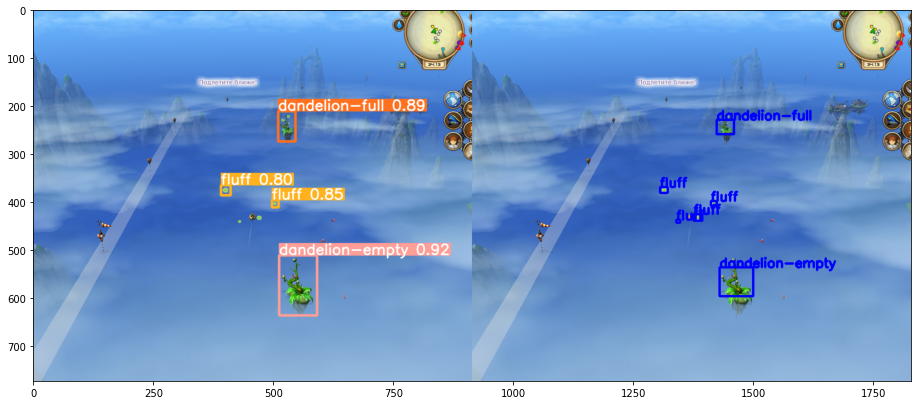

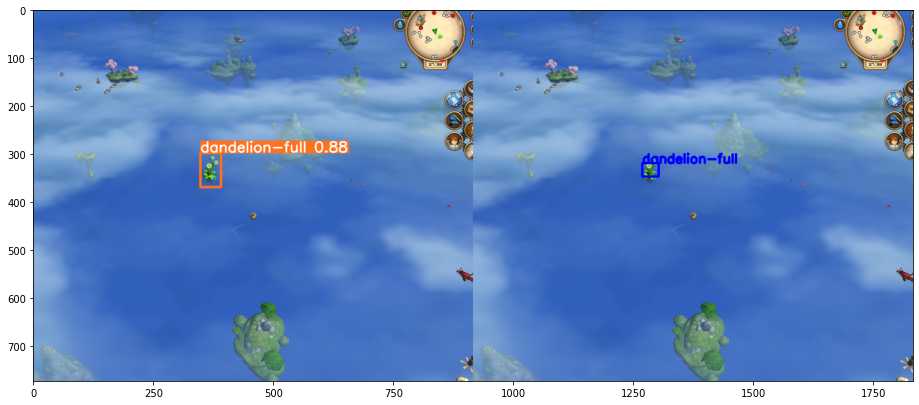

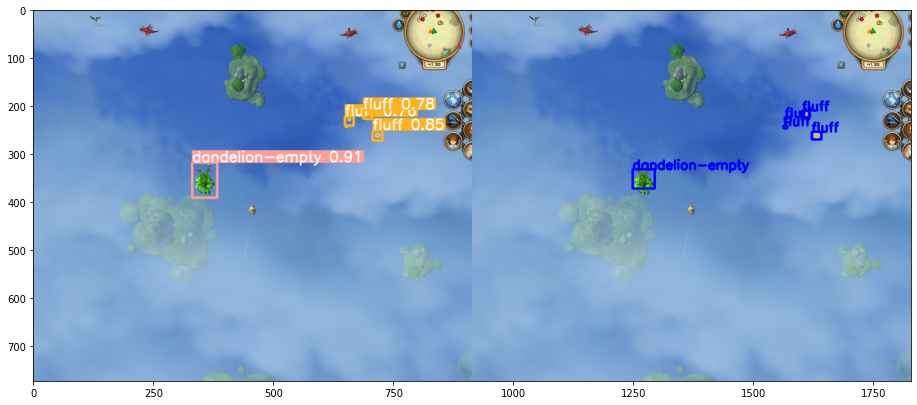

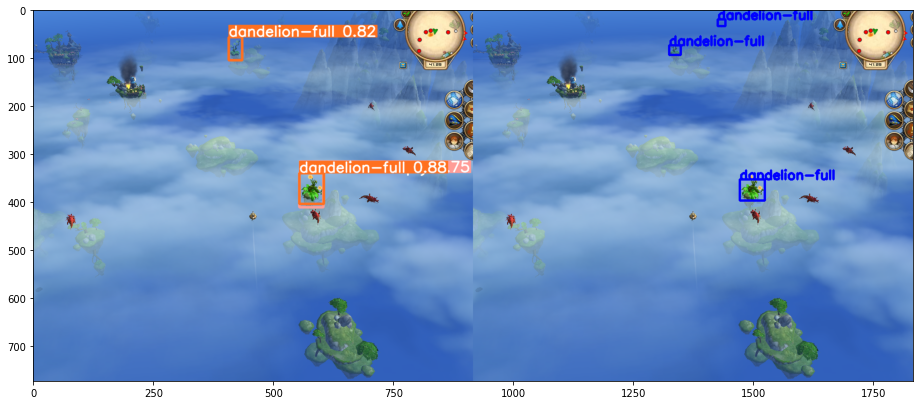

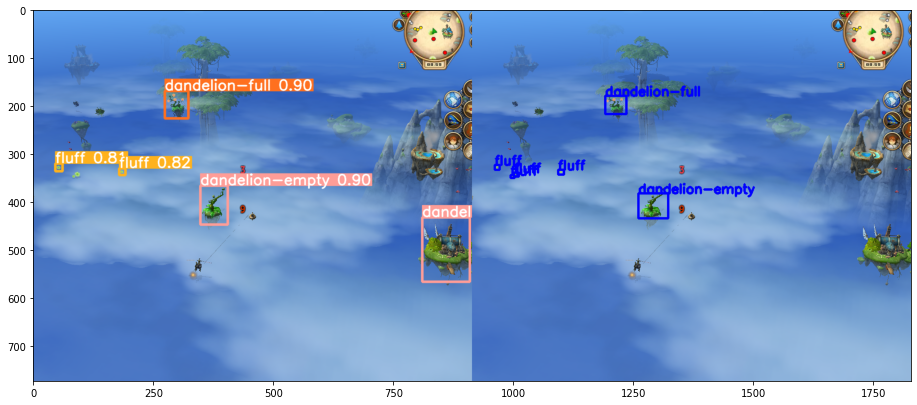

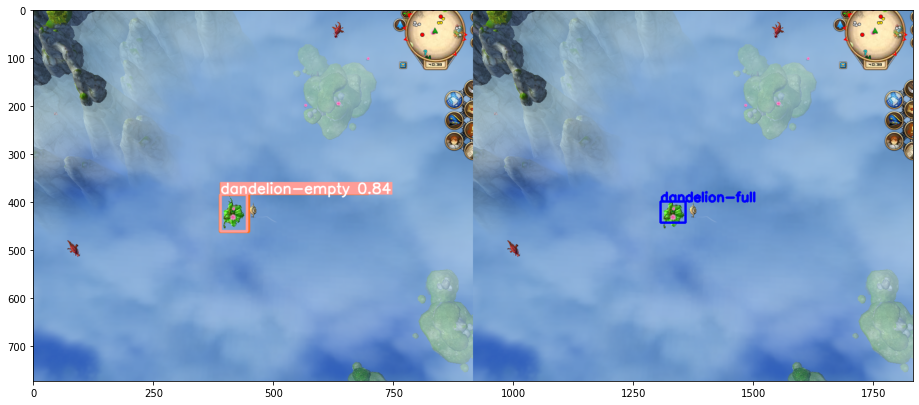

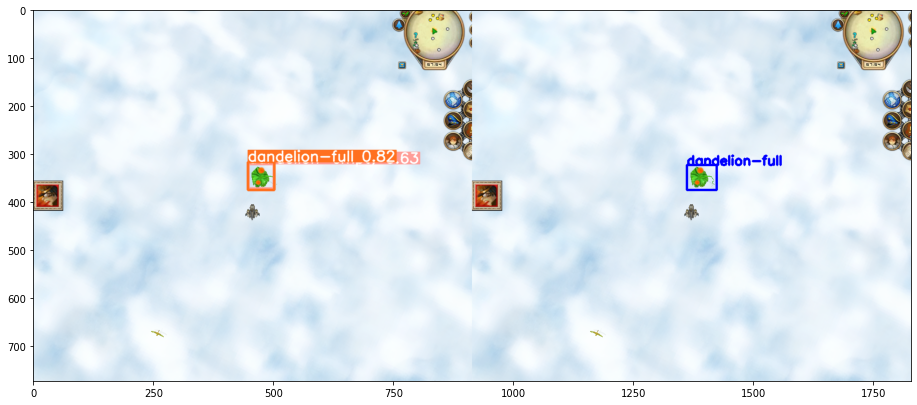

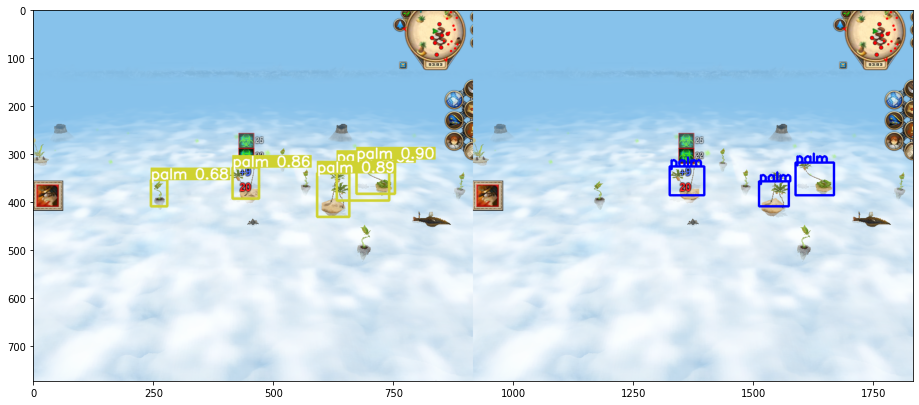

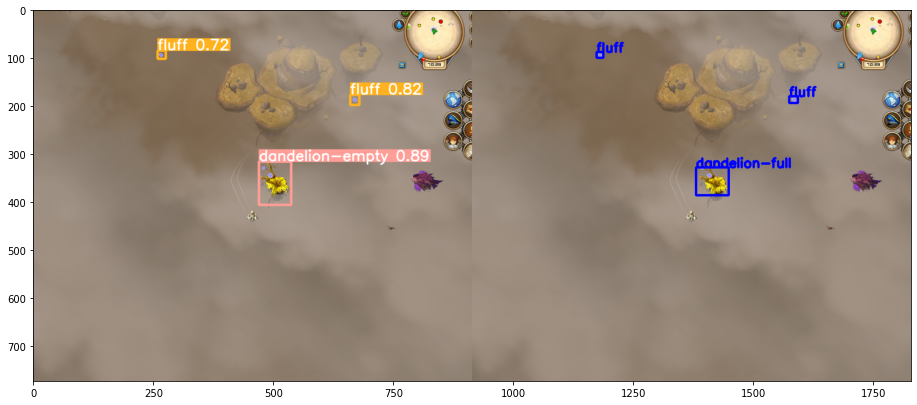

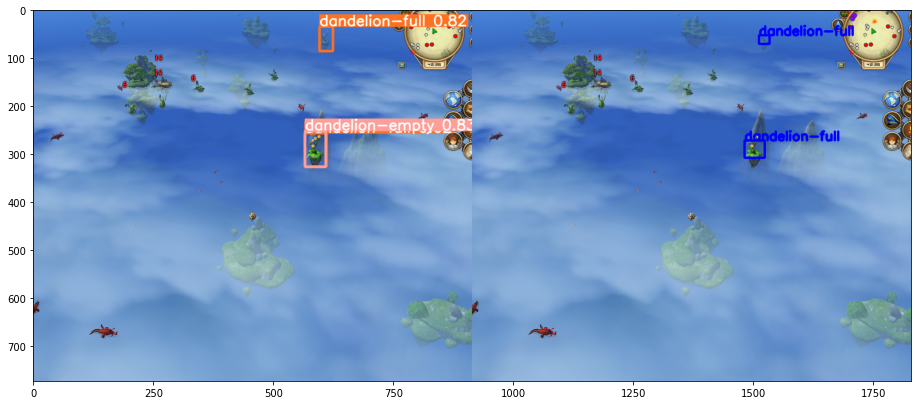

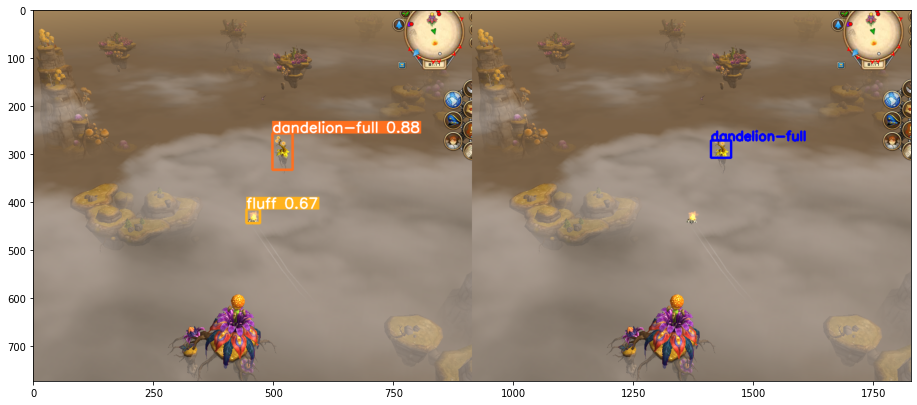

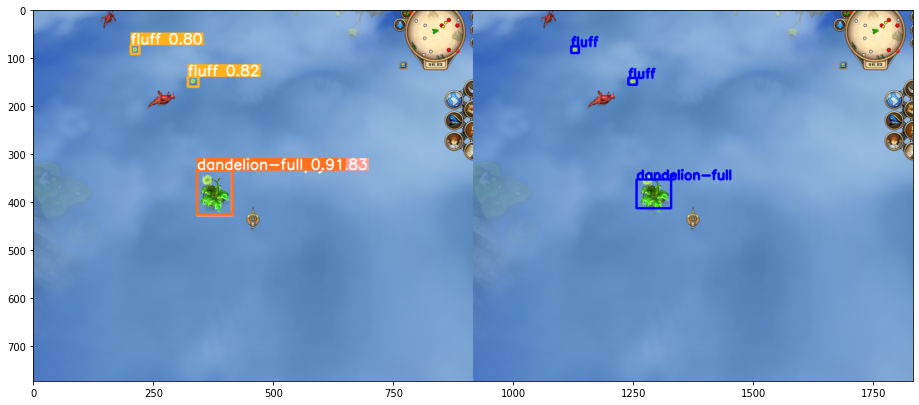

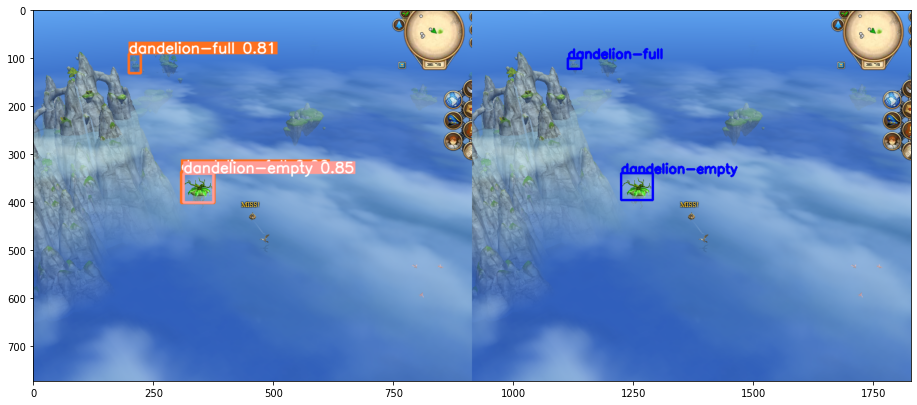

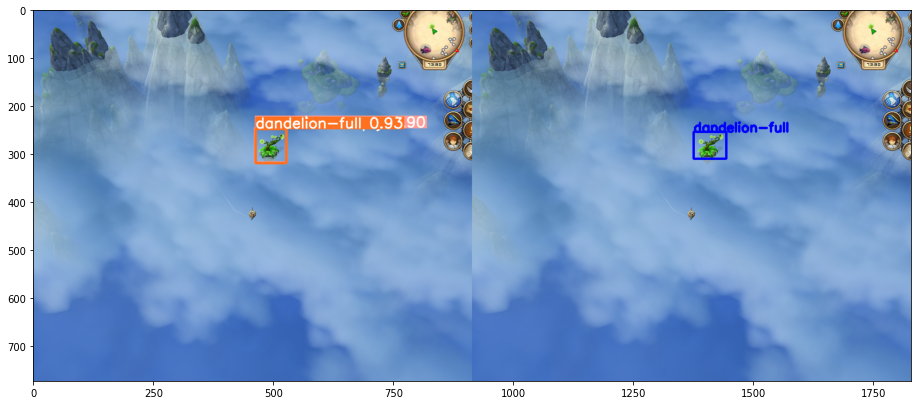

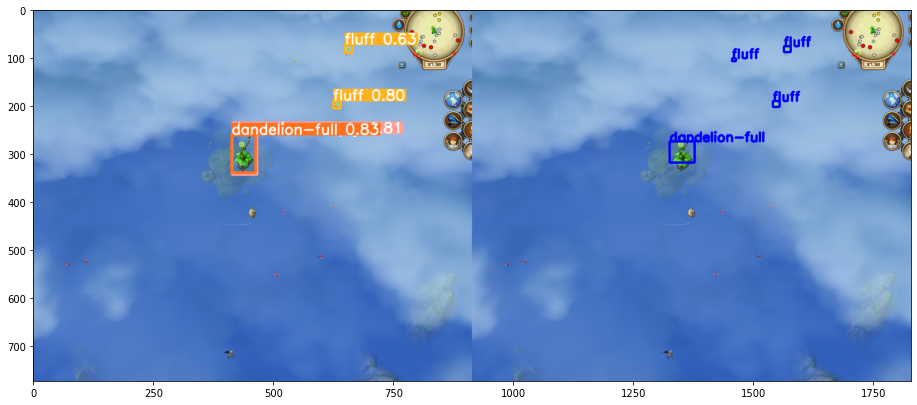

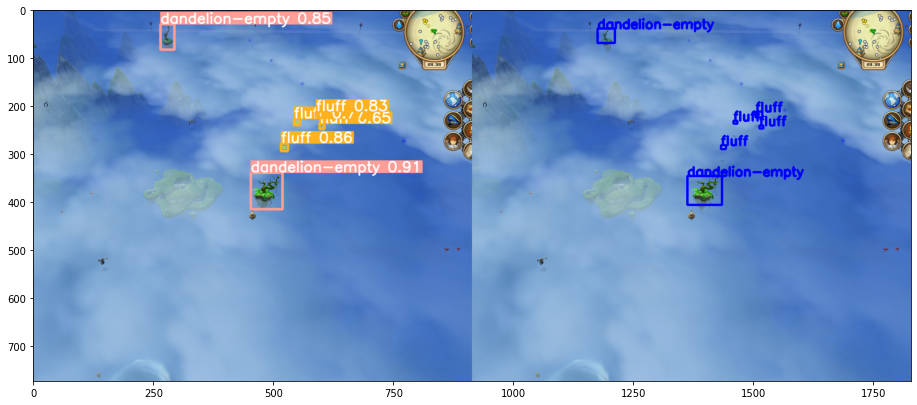

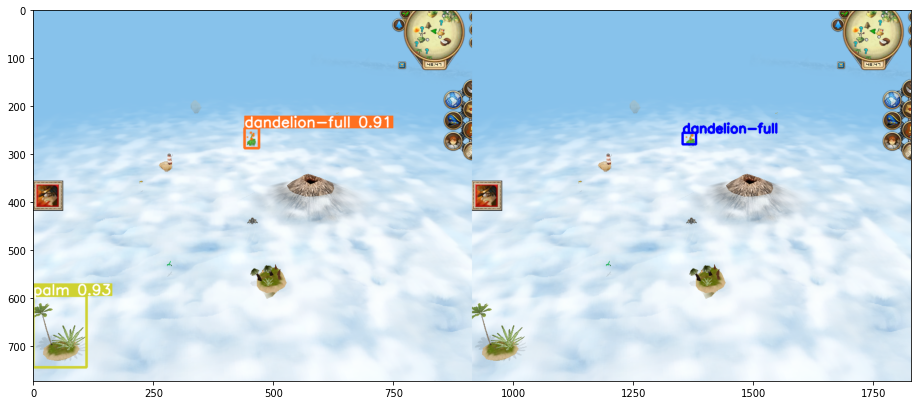

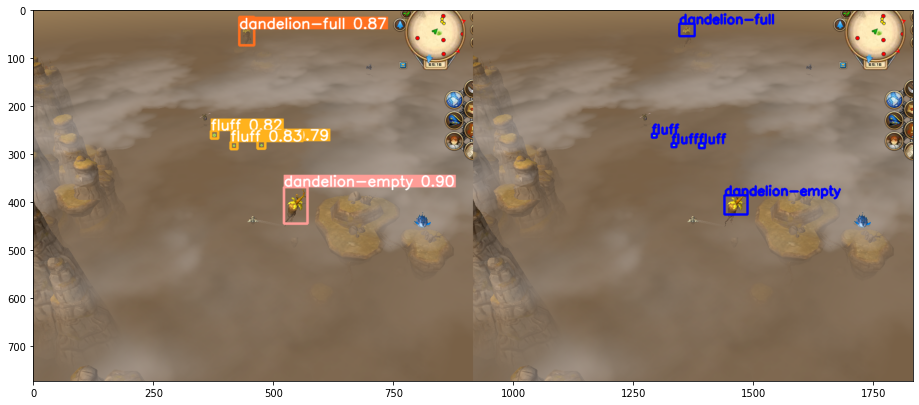

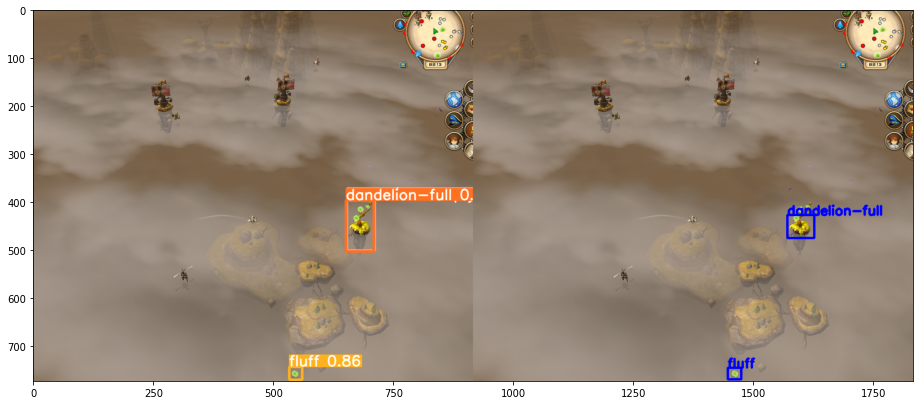

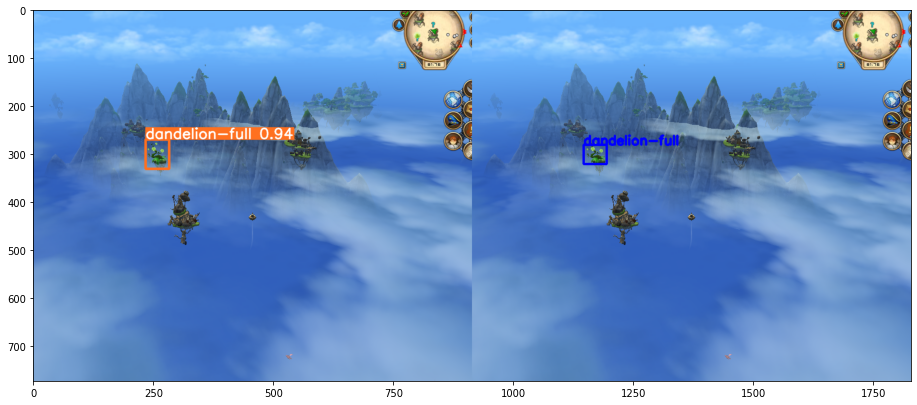

In [25]:
for image in stacked_images:
  fig = plt.figure(figsize=(40, 15))
  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(image)

# Save model

To save your model just download **best.pt** file from PROJECT_FOLDER -> feature_extraction *(your best)* -> weights -> **best.pt**

File **best.pt** will be used to load it in your project to predict. 